# Instructions: 

In [1]:
# Please paste the glove.6B.100d in the root directory
# To download the glove.6B.100d, please use the link below
# https://drive.google.com/file/d/163puQBD6CGuRK15yT8cnO_C0KC0Pd6WA/view
# Task B is also included in this notebook

### Loading Libraries

In [24]:
#Avoid running this cell if you have already installed the required packages
%pip install seaborn tensorflow numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.metrics import Precision, Recall 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import os


# TASK A

### Loading Data

In [26]:
data = pd.read_csv('train_all_tasks.csv')

### VIsualising Data

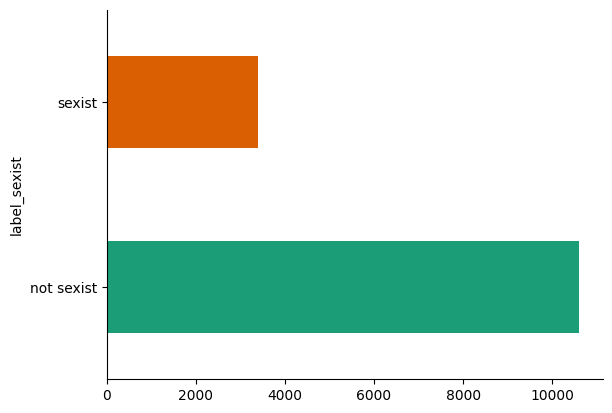

In [27]:

data.groupby('label_sexist').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Labeling Data

In [28]:
text = data['text']
data['label_sexist'] = data['label_sexist'].map({'sexist': 0, 'not sexist': 1})
labels = data['label_sexist']

data.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",1,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",1,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,1,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,1,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,1,none,none


### Load Glove Embeddings

In [29]:
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_path)

### Tokenization

In [30]:
tokenizer = Tokenizer(num_words = 40000)
tokenizer.fit_on_texts(text)

seq = tokenizer.texts_to_sequences(text)
word_index = tokenizer.word_index
data_padded = pad_sequences(seq, maxlen=256)


In [31]:
emd_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        emd_matrix[i] = embedding_vector

### Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels, test_size=0.2, random_state=42)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(11200, 256) (2800, 256) (11200,) (2800,)


### Plotting Function

In [33]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()


### Bi-Directional LSTM Model

In [34]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 100, weights=[emd_matrix], input_length=256, trainable=False))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall()])
model.summary()

c:\Users\zawad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,262,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,262,900 (8.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,262,900 (8.63 MB)

### Training Validation

Epoch 1/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.7428 - loss: 0.5694 - precision_2: 0.7642 - recall_1: 0.9598 - val_accuracy: 0.7486 - val_loss: 0.5392 - val_precision_2: 0.7486 - val_recall_1: 1.0000
Epoch 2/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.7636 - loss: 0.5120 - precision_2: 0.7700 - recall_1: 0.9814 - val_accuracy: 0.7786 - val_loss: 0.4770 - val_precision_2: 0.8358 - val_recall_1: 0.8764
Epoch 3/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8029 - loss: 0.4472 - precision_2: 0.8231 - recall_1: 0.9457 - val_accuracy: 0.8000 - val_loss: 0.4393 - val_precision_2: 0.8145 - val_recall_1: 0.9490
Epoch 4/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8189 - loss: 0.4235 - precision_2: 0.8326 - recall_1: 0.9524 - val_accuracy: 0.8050 - val_loss: 0.4334 - val_precision_2: 0.8143 - val_recall_1: 0.9580
Epoch 5/30
448/448 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.8272 - loss: 0.4047 - precision_2: 0.8352 - recall_1

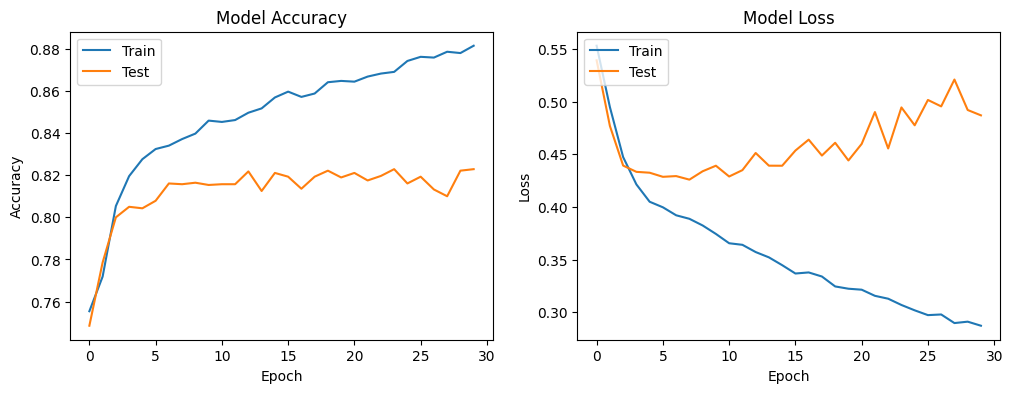

In [35]:
history=model.fit(X_train, y_train, epochs=30, batch_size=25, validation_data=(X_test, y_test))
train_loss, train_accuracy,train_precision,train_recall = model.evaluate(X_train, y_train)
print(f'Training Loss: {train_loss}')
print(f'Training Accuracy: {train_accuracy}')
print(f'Training Precison: {train_precision}')
print(f'Training Recall: {train_recall}')


# Evaluate Bidirectional LSTM model
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f'Bidirectional LSTM Model Test Loss : {test_loss}')
print(f'Bidirectional LSTM Model Test Accuracy: {test_accuracy}')
print(f'Bidirectional LSTM Model Test Precision: {test_precision}')
print(f'Bidirectional LSTM Model Test Recall: {test_recall}')
plot_history(history)

### Confusion Matrix

88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


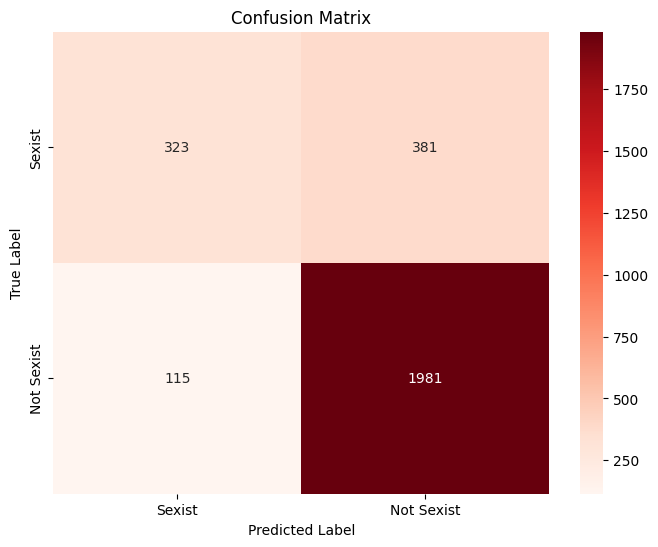

F1 Score: 0.8887393449977569


In [36]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Sexist', 'Not Sexist'], yticklabels=['Sexist', 'Not Sexist'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Calculate the F1 score

print('='*50)
f = f1_score(y_test, y_pred)
print(f"F1 Score: {f}")
print('='*50)

 # TASK B

### Modified Dataset

In [37]:
data1 = pd.read_csv('train_all_tasks.csv')

data1 =data1[data1['label_category'] != 'none']
text1 = data1['text']
data1.head()

,rewire_id,text,label_sexist,label_category,label_vector
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
11,sexism2022_english-760,They get the initial chance because they are a...,sexist,2. derogation,2.1 descriptive attacks
17,sexism2022_english-1108,ugly chicks A pussy is a pussy.,sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
18,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,sexist,"1. threats, plans to harm and incitement",1.2 incitement and encouragement of harm
19,sexism2022_english-10014,How about I talk shit to an idiot like you? Ar...,sexist,3. animosity,"3.1 casual use of gendered slurs, profanities,..."


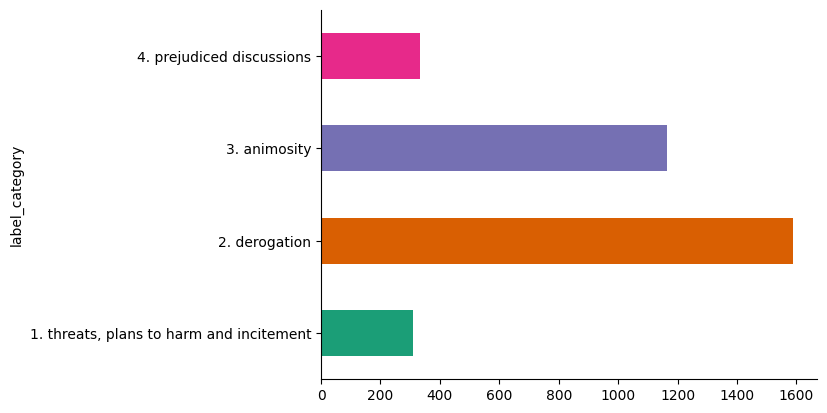

In [38]:
data1.groupby('label_category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [39]:
#Feeding dummy boleean data

labels1 = data1['label_category']
labels1 = pd.get_dummies(data1['label_category'], dtype=int)


### Tokenization

In [40]:
tokenizer1 = Tokenizer(num_words = 40000)
tokenizer1.fit_on_texts(text1)
seq1 = tokenizer1.texts_to_sequences(text1)
word_index1 = tokenizer1.word_index
padded_data1 = pad_sequences(seq1, maxlen=256)

In [41]:
emd_matrix1 = np.zeros((len(word_index1) + 1, 100))
for word, i in word_index1.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        emd_matrix1[i] = embedding_vector

### Spiltting Training Testing 

In [42]:
X1_train, X1_test, y1_train, y1_test = train_test_split(padded_data1, labels1, test_size=0.2, random_state=42)
print(X1_train.shape, X1_test.shape, y1_train.shape, y1_test.shape)

(2718, 256) (680, 256) (2718, 4) (680, 4)


### Bi-Directional LSTM Model with Softmax

In [43]:
modelB = Sequential()
modelB.add(Embedding(len(word_index1) + 1, 100, weights=[emd_matrix1], input_length=256, trainable=True))
modelB.add(Bidirectional(LSTM(128)))
modelB.add(Dense(52, activation='relu'))
modelB.add(Dropout(0.3))
modelB.add(Dense(4, activation='softmax'))
modelB.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision()])
modelB.summary()




# Bidirectional LSTM Model Test Accuracy: 0.550000011920929
# Bidirectional LSTM Model Test Precision: 0.5472561120986938
# Bidirectional LSTM Model Test Recall: 0.5279411673545837


c:\Users\zawad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │       954,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,100 (3.64 MB)

 Trainable params: 954,100 (3.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Validation

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.3971 - loss: 1.2237 - precision_3: 0.3883 - val_accuracy: 0.4868 - val_loss: 1.1337 - val_precision_3: 1.0000
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.4627 - loss: 1.1139 - precision_3: 0.5107 - val_accuracy: 0.5074 - val_loss: 1.0782 - val_precision_3: 0.6602
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.5205 - loss: 1.0302 - precision_3: 0.5538 - val_accuracy: 0.5132 - val_loss: 1.0618 - val_precision_3: 0.5726
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.6027 - loss: 0.9024 - precision_3: 0.6598 - val_accuracy: 0.5382 - val_loss: 1.0061 - val_precision_3: 0.5601
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 204ms/step - accuracy: 0.6705 - loss: 0.7726 - precision_3: 0.7260 - val_accuracy: 0.5750 - val_loss: 1.0484 - val_precision_3: 0.5929
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - accuracy: 0.7639 - loss: 0.5869 - precision_3: 0.7854 - val_

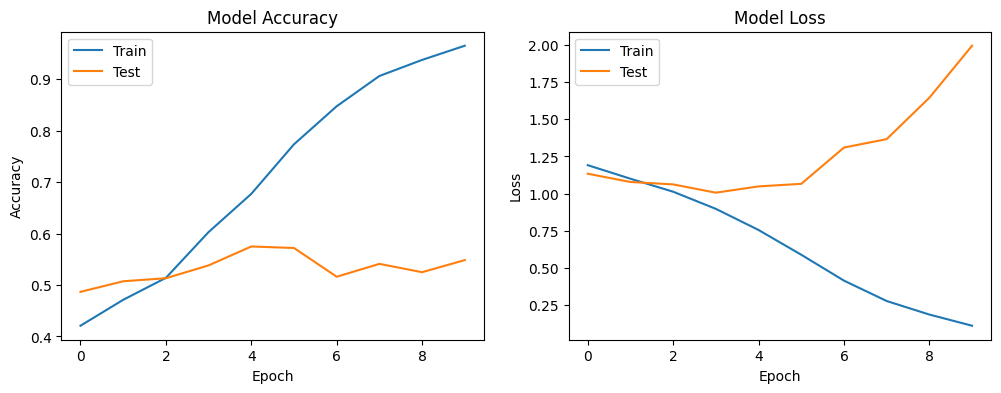

In [44]:
historyB=modelB.fit(X1_train, y1_train, epochs=10, batch_size=50, validation_data=(X1_test, y1_test))
trainB_loss, trainB_accuracy,trainB_precision = modelB.evaluate(X1_train, y1_train)

print('='*50)
print(f'Training Loss: {trainB_loss}')
print(f'Training Accuracy: {trainB_accuracy}')
print(f'Training Precison: {trainB_precision}')

print('='*50)



# Evaluate Bidirectional LSTM model
testB_loss, testB_accuracy, testB_precision = modelB.evaluate(X1_test, y1_test)

print('='*50)
print(f'Test Loss: {testB_loss}')
print(f'Test Accuracy: {testB_accuracy}')
print(f'Test Precision: {testB_precision}')

print('='*50)

plot_history(historyB)